In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [2]:
# hide
from utils import *
setup_chapter()

Using transformers v4.55.4
Using datasets v2.21.0


# Dealing with Few to No Labels

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="images/chapter09_decision-tree.png" id="decision-tree"/>

## Building a GitHub Issues Tagger

<img alt="issue-example" caption="A typical GitHub issue on the Transformers repository" src="images/chapter09_issue-example-v2.png" id="issue-example"/> 

### Getting the Data

#hide
### REPO ONLY: Code to Download Issues
If you want to download the issues yourself, you can query the Issues endpoint by using the _Requests_ library, which is the standard way for making HTTP requests in Python. Here is a function to fetch the issues from the Transformers repository:

In [3]:
#hide
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000, 
                 rate_limit=5_000):    
    batch = []
    all_issues = []
    per_page = 100 # Number of issues to return per page
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"
    
    for page in tqdm(range(num_pages)):
        # Query with state=all to get both open and closed issues
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = [] # Flush batch for next time period
            print(f"Reached GitHub rate limit. Sleeping for one hour ...")
            time.sleep(60 * 60 + 1)
            
    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

#hide

Now when you call `fetch_issues()`, it will download all the issues in batches to avoid exceeding GitHub's limit on the number of requests per hour. The results will be stored in an _github-issues-transformers.jsonl_ file, where each line is a JSON object the represents the issue. 

### Preparing the Data

In [4]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [5]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [6]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [7]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [8]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [9]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [10]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [11]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [12]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit
tokenization step. While recent tokenization approaches based on data-derived
subword lexicons are less brittle than manually en

labels: ['new model']



In [13]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [14]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


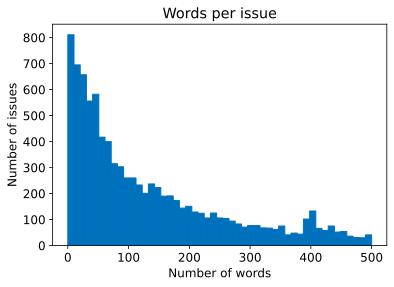

In [15]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

### Creating Training Sets

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [17]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, 
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [18]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [19]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

### Creating Training Slices

In [20]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))
        
# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [21]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


## Implementing a Naive Bayesline

In [22]:
#hide_output
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [23]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [25]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, 
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, 
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

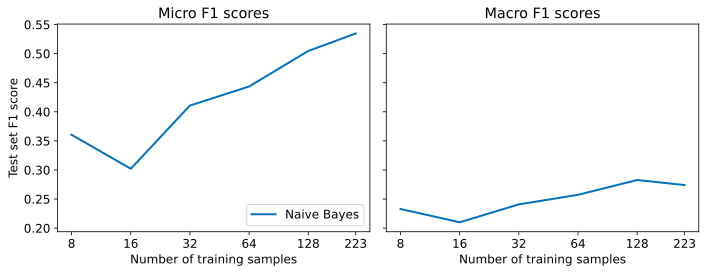

In [26]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

## Working with No Labeled Data

In [27]:
#hide_output
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

In [28]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:  0.103%
Token lions:    0.066%
Token birds:    0.025%
Token love:     0.015%
Token hunting:  0.013%


In [29]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:  0.103%
Token cars:     0.001%


In [30]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:     0.139%
Token animals:  0.006%


In [31]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

In [32]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [33]:
# hide_output
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

In [34]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [35]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
        output_dict=True)

In [36]:
#hide_output
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

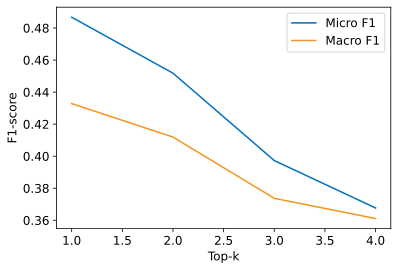

In [37]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [38]:
#hide_output
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

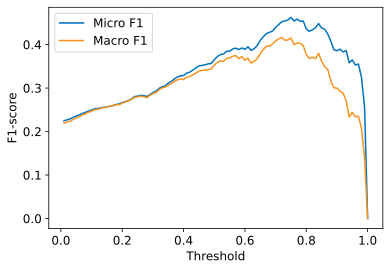

In [39]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [40]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (micro): 0.72 with F1-score 0.42.


In [41]:
#hide_output
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

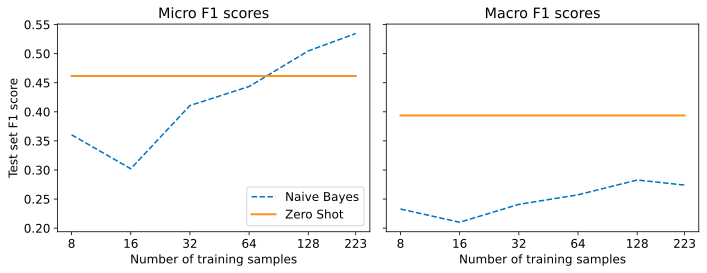

In [42]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

## Working with a Few Labels

### Data Augmentation

In [43]:
#hide
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                                device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)
for k,v in augs.items():
    print(f"Original text: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
synonym_replace: Even if you kill me Megatron, others will prove to defeat your
tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
random_insert: even if you defeat me megatron, others humanity will rise to
defeat your tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
random_swap: You even if defeat me Megatron, others will rise defeat to tyranny
your

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
random_delete: Even if you me Megatron, others to defeat tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
bt_en_de: Even if you defeat me, Megatron, others will rise up to conquer your
tyranny, to defeat your tyranny, and I will not be defeated by you, and I will
be defeated by you, and I will be defeated by you, and I will be defe

In [44]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                                device="cpu", action="substitute")

text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: transformers ' the most popular toys


In [45]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += [aug.augment(text)]
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

In [46]:
#hide
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    # Flatten augmentations and align labels!
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

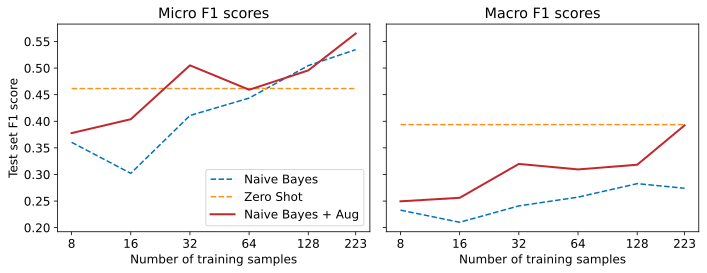

In [47]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

### Using Embeddings as a Lookup Table

<img alt="nearest-neighbours" caption="An illustration of nearest neighbor embedding lookup" src="images/chapter09_nearest-neighbours.png" id="nearest-neighbours"/>

In [48]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [49]:
# hide_output
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [50]:
# hide_output
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [51]:
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

QUERY LABELS: ['new model']
QUERY TEXT:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self
attention methods such as Linformer, Performer and [...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
SCORE: 54.92
LABELS: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to
Transformers library?
## Model description
The n [...]
SCORE: 57.90
LABELS: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based
models with sign [...]
SCORE: 60.12
LABELS: ['new model']


In [52]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [53]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

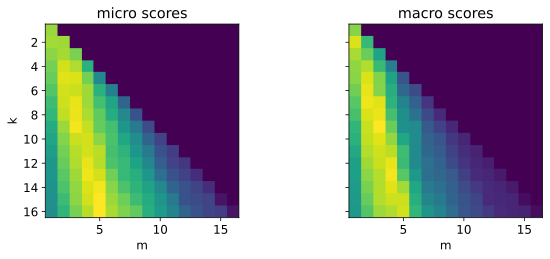

In [54]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [55]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


In [56]:
# hide_output
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice 
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

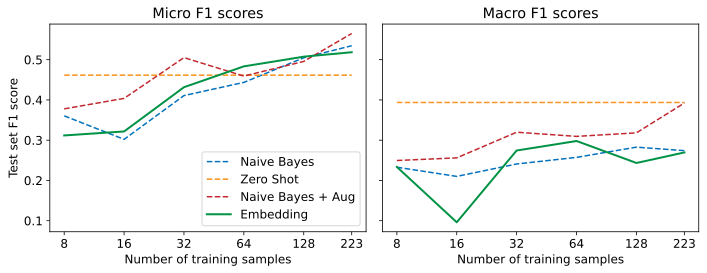

In [57]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

### Sidebar: Efficient Similarity Search with FAISS

<img alt="faiss-index" caption="The structure of a FAISS index: the gray points represent data points added to the index, the bold black points are the cluster centers found via k-means clustering, and the colored areas represent the regions belonging to a cluster center" src="images/chapter09_faiss-index.png" id="faiss-index"/>

### End sidebar

### Fine-Tuning a Vanilla Transformer

In [58]:
#hide_output
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)
                          
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [59]:
#hide_output
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [60]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0, 
    eval_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

In [61]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)
    
    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

In [62]:
#hide_output
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [63]:
# hide_output
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

/tmp/ipykernel_666749/3071368636.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6519, 'grad_norm': 2.9537792205810547, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5933027267456055, 'eval_micro f1': 0.2155688622754491, 'eval_macro f1': 0.08544973544973546, 'eval_runtime': 0.1798, 'eval_samples_per_second': 589.589, 'eval_steps_per_second': 5.562, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5895, 'grad_norm': 2.3826215267181396, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5781899690628052, 'eval_micro f1': 0.12121212121212122, 'eval_macro f1': 0.051038310060866454, 'eval_runtime': 0.1055, 'eval_samples_per_second': 1004.751, 'eval_steps_per_second': 9.479, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5736, 'grad_norm': 2.4808952808380127, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5646090507507324, 'eval_micro f1': 0.02877697841726619, 'eval_macro f1': 0.02818035426731079, 'eval_runtime': 0.1057, 'eval_samples_per_second': 1002.585, 'eval_steps_per_second': 9.458, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5616, 'grad_norm': 2.3611104488372803, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.5497399568557739, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0972, 'eval_samples_per_second': 1090.167, 'eval_steps_per_second': 10.285, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5354, 'grad_norm': 2.2363433837890625, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.5327252149581909, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0977, 'eval_samples_per_second': 1084.937, 'eval_steps_per_second': 10.235, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5195, 'grad_norm': 2.02313232421875, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.5164503455162048, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1056, 'eval_samples_per_second': 1003.633, 'eval_steps_per_second': 9.468, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4976, 'grad_norm': 1.7539722919464111, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.5023665428161621, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1056, 'eval_samples_per_second': 1004.072, 'eval_steps_per_second': 9.472, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4851, 'grad_norm': 1.7252836227416992, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.48894116282463074, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1037, 'eval_samples_per_second': 1021.832, 'eval_steps_per_second': 9.64, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4719, 'grad_norm': 1.6614456176757812, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.47417768836021423, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0995, 'eval_samples_per_second': 1064.906, 'eval_steps_per_second': 10.046, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4474, 'grad_norm': 1.462983250617981, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.46174606680870056, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1061, 'eval_samples_per_second': 998.969, 'eval_steps_per_second': 9.424, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4317, 'grad_norm': 1.4290854930877686, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.4514922797679901, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0968, 'eval_samples_per_second': 1095.229, 'eval_steps_per_second': 10.332, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4365, 'grad_norm': 1.4364162683486938, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.4450243413448334, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1075, 'eval_samples_per_second': 986.492, 'eval_steps_per_second': 9.307, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4005, 'grad_norm': 1.2674741744995117, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.43641871213912964, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0977, 'eval_samples_per_second': 1085.212, 'eval_steps_per_second': 10.238, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3972, 'grad_norm': 1.2830665111541748, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.42893022298812866, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1059, 'eval_samples_per_second': 1000.892, 'eval_steps_per_second': 9.442, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3915, 'grad_norm': 1.308916687965393, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.42151400446891785, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1056, 'eval_samples_per_second': 1004.118, 'eval_steps_per_second': 9.473, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3881, 'grad_norm': 1.165272831916809, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.41443806886672974, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0976, 'eval_samples_per_second': 1086.283, 'eval_steps_per_second': 10.248, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3783, 'grad_norm': 1.115283727645874, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.4116983711719513, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0977, 'eval_samples_per_second': 1084.527, 'eval_steps_per_second': 10.231, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3791, 'grad_norm': 1.1094236373901367, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.40698543190956116, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1052, 'eval_samples_per_second': 1007.606, 'eval_steps_per_second': 9.506, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.366, 'grad_norm': 1.072418212890625, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.40104755759239197, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0976, 'eval_samples_per_second': 1085.766, 'eval_steps_per_second': 10.243, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3557, 'grad_norm': 1.0248879194259644, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.3977760672569275, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.097, 'eval_samples_per_second': 1092.642, 'eval_steps_per_second': 10.308, 'epoch': 20.0}
{'train_runtime': 48.1494, 'train_samples_per_second': 4.154, 'train_steps_per_second': 0.415, 'train_loss': 0.462895530462265, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/3071368636.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6939, 'grad_norm': 2.2943999767303467, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6292290091514587, 'eval_micro f1': 0.07761194029850746, 'eval_macro f1': 0.025918775918775918, 'eval_runtime': 0.1154, 'eval_samples_per_second': 918.659, 'eval_steps_per_second': 8.667, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6219, 'grad_norm': 2.6462342739105225, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.6021024584770203, 'eval_micro f1': 0.1285140562248996, 'eval_macro f1': 0.052754435107376284, 'eval_runtime': 0.1128, 'eval_samples_per_second': 939.97, 'eval_steps_per_second': 8.868, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5951, 'grad_norm': 2.9573960304260254, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5749329924583435, 'eval_micro f1': 0.23076923076923078, 'eval_macro f1': 0.04892966360856269, 'eval_runtime': 0.1126, 'eval_samples_per_second': 941.351, 'eval_steps_per_second': 8.881, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5466, 'grad_norm': 2.0736262798309326, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.5313593149185181, 'eval_micro f1': 0.11180124223602485, 'eval_macro f1': 0.04169101889733099, 'eval_runtime': 0.1136, 'eval_samples_per_second': 933.332, 'eval_steps_per_second': 8.805, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5208, 'grad_norm': 2.5327656269073486, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.5109171867370605, 'eval_micro f1': 0.07352941176470588, 'eval_macro f1': 0.027777777777777776, 'eval_runtime': 0.1147, 'eval_samples_per_second': 924.284, 'eval_steps_per_second': 8.72, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4898, 'grad_norm': 2.301720142364502, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.48463529348373413, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1125, 'eval_samples_per_second': 942.075, 'eval_steps_per_second': 8.887, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4605, 'grad_norm': 1.8571416139602661, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.457797646522522, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.112, 'eval_samples_per_second': 946.143, 'eval_steps_per_second': 8.926, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.441, 'grad_norm': 2.086198091506958, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.4409414827823639, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0994, 'eval_samples_per_second': 1066.472, 'eval_steps_per_second': 10.061, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4236, 'grad_norm': 2.3995792865753174, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.4302789866924286, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1127, 'eval_samples_per_second': 940.676, 'eval_steps_per_second': 8.874, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4084, 'grad_norm': 2.1073503494262695, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.4199976921081543, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1168, 'eval_samples_per_second': 907.662, 'eval_steps_per_second': 8.563, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3812, 'grad_norm': 1.8860787153244019, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.40191248059272766, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1139, 'eval_samples_per_second': 930.614, 'eval_steps_per_second': 8.779, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3621, 'grad_norm': 2.1840877532958984, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.4085541069507599, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1144, 'eval_samples_per_second': 926.804, 'eval_steps_per_second': 8.743, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3696, 'grad_norm': 2.030782461166382, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.39768892526626587, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.51, 'eval_steps_per_second': 8.939, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3596, 'grad_norm': 1.9169409275054932, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.38598769903182983, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.941, 'eval_steps_per_second': 8.962, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3359, 'grad_norm': 1.4618831872940063, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.3803535997867584, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.679, 'eval_steps_per_second': 8.959, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3545, 'grad_norm': 2.580415964126587, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.3741989731788635, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0958, 'eval_samples_per_second': 1106.115, 'eval_steps_per_second': 10.435, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3346, 'grad_norm': 1.7876923084259033, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.3747765123844147, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1135, 'eval_samples_per_second': 933.808, 'eval_steps_per_second': 8.81, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3467, 'grad_norm': 1.5056238174438477, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.37352269887924194, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0844, 'eval_samples_per_second': 1255.907, 'eval_steps_per_second': 11.848, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3309, 'grad_norm': 1.6707313060760498, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.3648606836795807, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1024, 'eval_samples_per_second': 1034.72, 'eval_steps_per_second': 9.762, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3042, 'grad_norm': 1.5958799123764038, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.3669128715991974, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1109, 'eval_samples_per_second': 955.944, 'eval_steps_per_second': 9.018, 'epoch': 20.0}
{'train_runtime': 49.1485, 'train_samples_per_second': 7.732, 'train_steps_per_second': 0.814, 'train_loss': 0.4340338870882988, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/3071368636.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6762, 'grad_norm': 2.4731738567352295, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6186661720275879, 'eval_micro f1': 0.1118421052631579, 'eval_macro f1': 0.05890146241023434, 'eval_runtime': 0.1121, 'eval_samples_per_second': 945.173, 'eval_steps_per_second': 8.917, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6073, 'grad_norm': 3.018181324005127, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5890713334083557, 'eval_micro f1': 0.22807017543859648, 'eval_macro f1': 0.04585537918871252, 'eval_runtime': 0.1134, 'eval_samples_per_second': 934.864, 'eval_steps_per_second': 8.819, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5525, 'grad_norm': 2.346750020980835, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.528776228427887, 'eval_micro f1': 0.04519774011299435, 'eval_macro f1': 0.014336917562724014, 'eval_runtime': 0.1141, 'eval_samples_per_second': 928.843, 'eval_steps_per_second': 8.763, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5133, 'grad_norm': 3.3277394771575928, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.48747172951698303, 'eval_micro f1': 0.04838709677419355, 'eval_macro f1': 0.022222222222222223, 'eval_runtime': 0.1148, 'eval_samples_per_second': 923.32, 'eval_steps_per_second': 8.711, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4725, 'grad_norm': 2.7062551975250244, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.463747501373291, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1123, 'eval_samples_per_second': 944.204, 'eval_steps_per_second': 8.908, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4378, 'grad_norm': 1.6295346021652222, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.43880096077919006, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.203, 'eval_steps_per_second': 8.945, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4186, 'grad_norm': 1.4607454538345337, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.4151228368282318, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.45, 'eval_steps_per_second': 8.957, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.391, 'grad_norm': 1.8774309158325195, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.3998057246208191, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1132, 'eval_samples_per_second': 936.507, 'eval_steps_per_second': 8.835, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3691, 'grad_norm': 1.3369669914245605, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.3917127251625061, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1108, 'eval_samples_per_second': 956.713, 'eval_steps_per_second': 9.026, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3616, 'grad_norm': 1.0716747045516968, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.3797614574432373, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1115, 'eval_samples_per_second': 950.366, 'eval_steps_per_second': 8.966, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3484, 'grad_norm': 1.2587473392486572, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.37571388483047485, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1114, 'eval_samples_per_second': 951.582, 'eval_steps_per_second': 8.977, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3312, 'grad_norm': 1.1394505500793457, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.36710602045059204, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.883, 'eval_steps_per_second': 8.905, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3253, 'grad_norm': 1.2086546421051025, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.363047331571579, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.373, 'eval_steps_per_second': 8.947, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3266, 'grad_norm': 1.0822035074234009, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.35844022035598755, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1116, 'eval_samples_per_second': 950.004, 'eval_steps_per_second': 8.962, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3143, 'grad_norm': 1.3328027725219727, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.35506388545036316, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1126, 'eval_samples_per_second': 941.441, 'eval_steps_per_second': 8.882, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3067, 'grad_norm': 1.1285839080810547, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.3526504337787628, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1115, 'eval_samples_per_second': 950.319, 'eval_steps_per_second': 8.965, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2906, 'grad_norm': 1.1317343711853027, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.3513984680175781, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1132, 'eval_samples_per_second': 936.189, 'eval_steps_per_second': 8.832, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2919, 'grad_norm': 1.034883737564087, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.3468560576438904, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1122, 'eval_samples_per_second': 945.049, 'eval_steps_per_second': 8.916, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2818, 'grad_norm': 1.6442445516586304, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.34527328610420227, 'eval_micro f1': 0.1076923076923077, 'eval_macro f1': 0.05004789272030651, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.943, 'eval_steps_per_second': 8.905, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2858, 'grad_norm': 0.9557939767837524, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.3484341502189636, 'eval_micro f1': 0.04878048780487805, 'eval_macro f1': 0.022222222222222223, 'eval_runtime': 0.1143, 'eval_samples_per_second': 927.117, 'eval_steps_per_second': 8.746, 'epoch': 20.0}
{'train_runtime': 53.547, 'train_samples_per_second': 13.446, 'train_steps_per_second': 1.121, 'train_loss': 0.39512146015961963, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/3071368636.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6605, 'grad_norm': 2.6111507415771484, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6020369529724121, 'eval_micro f1': 0.22807017543859648, 'eval_macro f1': 0.04659498207885305, 'eval_runtime': 0.1126, 'eval_samples_per_second': 941.207, 'eval_steps_per_second': 8.879, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5686, 'grad_norm': 2.0720419883728027, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5230942368507385, 'eval_micro f1': 0.03614457831325301, 'eval_macro f1': 0.013071895424836602, 'eval_runtime': 0.1121, 'eval_samples_per_second': 945.587, 'eval_steps_per_second': 8.921, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4995, 'grad_norm': 6.114516258239746, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.4618006944656372, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.968, 'eval_steps_per_second': 8.962, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.439, 'grad_norm': 1.4851593971252441, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.41578811407089233, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.382, 'eval_steps_per_second': 8.824, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3936, 'grad_norm': 1.3379080295562744, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.3939521312713623, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1132, 'eval_samples_per_second': 936.477, 'eval_steps_per_second': 8.835, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3692, 'grad_norm': 0.9420852065086365, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.37927111983299255, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1112, 'eval_samples_per_second': 953.122, 'eval_steps_per_second': 8.992, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3558, 'grad_norm': 1.2087714672088623, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.3689953684806824, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1128, 'eval_samples_per_second': 939.686, 'eval_steps_per_second': 8.865, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3441, 'grad_norm': 0.9147769808769226, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.36588379740715027, 'eval_micro f1': 0.1897810218978102, 'eval_macro f1': 0.07046070460704607, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.264, 'eval_steps_per_second': 8.946, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3425, 'grad_norm': 1.350036382675171, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.3614761531352997, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.38, 'eval_steps_per_second': 8.824, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3291, 'grad_norm': 1.3594187498092651, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.3606196939945221, 'eval_micro f1': 0.2517482517482518, 'eval_macro f1': 0.0851063829787234, 'eval_runtime': 0.1124, 'eval_samples_per_second': 943.066, 'eval_steps_per_second': 8.897, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3198, 'grad_norm': 1.7353577613830566, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.34405824542045593, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1112, 'eval_samples_per_second': 952.951, 'eval_steps_per_second': 8.99, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2958, 'grad_norm': 1.4590269327163696, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.3339690566062927, 'eval_micro f1': 0.21739130434782608, 'eval_macro f1': 0.07936507936507936, 'eval_runtime': 0.1111, 'eval_samples_per_second': 954.045, 'eval_steps_per_second': 9.0, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.295, 'grad_norm': 0.8958336114883423, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.3323960602283478, 'eval_micro f1': 0.21897810218978103, 'eval_macro f1': 0.0947399011915141, 'eval_runtime': 0.1129, 'eval_samples_per_second': 939.094, 'eval_steps_per_second': 8.859, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2906, 'grad_norm': 1.1925245523452759, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.3274765610694885, 'eval_micro f1': 0.1925925925925926, 'eval_macro f1': 0.08395061728395062, 'eval_runtime': 0.1122, 'eval_samples_per_second': 945.147, 'eval_steps_per_second': 8.916, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2797, 'grad_norm': 0.86688631772995, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.32280832529067993, 'eval_micro f1': 0.3013698630136986, 'eval_macro f1': 0.12526347485697079, 'eval_runtime': 0.1136, 'eval_samples_per_second': 933.245, 'eval_steps_per_second': 8.804, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2731, 'grad_norm': 1.0766046047210693, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.31863832473754883, 'eval_micro f1': 0.32432432432432434, 'eval_macro f1': 0.13436029097133076, 'eval_runtime': 0.1124, 'eval_samples_per_second': 942.642, 'eval_steps_per_second': 8.893, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2714, 'grad_norm': 1.4093469381332397, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.3145851492881775, 'eval_micro f1': 0.33557046979865773, 'eval_macro f1': 0.13674139255534604, 'eval_runtime': 0.1132, 'eval_samples_per_second': 936.321, 'eval_steps_per_second': 8.833, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2405, 'grad_norm': 1.1055169105529785, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.3104167878627777, 'eval_micro f1': 0.31724137931034485, 'eval_macro f1': 0.13209446380178086, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.069, 'eval_steps_per_second': 8.944, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2499, 'grad_norm': 1.0420970916748047, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.30875054001808167, 'eval_micro f1': 0.4177215189873418, 'eval_macro f1': 0.16464646464646465, 'eval_runtime': 0.1126, 'eval_samples_per_second': 941.048, 'eval_steps_per_second': 8.878, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2355, 'grad_norm': 1.088454008102417, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.3006777763366699, 'eval_micro f1': 0.4, 'eval_macro f1': 0.16020671834625322, 'eval_runtime': 0.1126, 'eval_samples_per_second': 941.309, 'eval_steps_per_second': 8.88, 'epoch': 20.0}
{'train_runtime': 56.5314, 'train_samples_per_second': 24.057, 'train_steps_per_second': 1.769, 'train_loss': 0.35265130519866944, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/3071368636.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6045, 'grad_norm': 2.108614921569824, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5116767287254333, 'eval_micro f1': 0.032, 'eval_macro f1': 0.01532567049808429, 'eval_runtime': 0.1135, 'eval_samples_per_second': 933.635, 'eval_steps_per_second': 8.808, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4534, 'grad_norm': 1.322011113166809, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.41297024488449097, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1108, 'eval_samples_per_second': 957.055, 'eval_steps_per_second': 9.029, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3845, 'grad_norm': 1.3693889379501343, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3721868693828583, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1098, 'eval_samples_per_second': 965.527, 'eval_steps_per_second': 9.109, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3527, 'grad_norm': 1.1670738458633423, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.35874679684638977, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1112, 'eval_samples_per_second': 953.167, 'eval_steps_per_second': 8.992, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3343, 'grad_norm': 0.9470493197441101, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.34219980239868164, 'eval_micro f1': 0.06451612903225806, 'eval_macro f1': 0.031746031746031744, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.653, 'eval_steps_per_second': 8.827, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3129, 'grad_norm': 0.9034754037857056, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.3327866196632385, 'eval_micro f1': 0.2571428571428571, 'eval_macro f1': 0.09090909090909091, 'eval_runtime': 0.1121, 'eval_samples_per_second': 945.97, 'eval_steps_per_second': 8.924, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3037, 'grad_norm': 1.0262725353240967, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.32609885931015015, 'eval_micro f1': 0.2571428571428571, 'eval_macro f1': 0.09090909090909091, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.482, 'eval_steps_per_second': 8.901, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2835, 'grad_norm': 1.2737984657287598, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.3187022805213928, 'eval_micro f1': 0.3287671232876712, 'eval_macro f1': 0.13131313131313133, 'eval_runtime': 0.1147, 'eval_samples_per_second': 923.798, 'eval_steps_per_second': 8.715, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2799, 'grad_norm': 0.9186217784881592, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.3134644329547882, 'eval_micro f1': 0.39473684210526316, 'eval_macro f1': 0.1592851592851593, 'eval_runtime': 0.1108, 'eval_samples_per_second': 956.771, 'eval_steps_per_second': 9.026, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2643, 'grad_norm': 1.1859217882156372, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.3061213493347168, 'eval_micro f1': 0.4, 'eval_macro f1': 0.15529815529815527, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.132, 'eval_steps_per_second': 8.935, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2549, 'grad_norm': 1.001130223274231, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.2986581325531006, 'eval_micro f1': 0.42038216560509556, 'eval_macro f1': 0.16617858168245764, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.538, 'eval_steps_per_second': 8.939, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2424, 'grad_norm': 0.8734905123710632, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.2898145318031311, 'eval_micro f1': 0.4230769230769231, 'eval_macro f1': 0.16790123456790124, 'eval_runtime': 0.1121, 'eval_samples_per_second': 945.708, 'eval_steps_per_second': 8.922, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2244, 'grad_norm': 0.8500992059707642, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.28136205673217773, 'eval_micro f1': 0.4472049689440994, 'eval_macro f1': 0.17420541108484372, 'eval_runtime': 0.1124, 'eval_samples_per_second': 943.342, 'eval_steps_per_second': 8.899, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2156, 'grad_norm': 0.8775279521942139, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.2734813094139099, 'eval_micro f1': 0.4727272727272727, 'eval_macro f1': 0.18106280193236715, 'eval_runtime': 0.1089, 'eval_samples_per_second': 973.284, 'eval_steps_per_second': 9.182, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1995, 'grad_norm': 0.775073766708374, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.2651998698711395, 'eval_micro f1': 0.46987951807228917, 'eval_macro f1': 0.1968178517198125, 'eval_runtime': 0.1118, 'eval_samples_per_second': 947.863, 'eval_steps_per_second': 8.942, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1839, 'grad_norm': 1.0337873697280884, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.26473113894462585, 'eval_micro f1': 0.46987951807228917, 'eval_macro f1': 0.17929724596391264, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.98, 'eval_steps_per_second': 8.83, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1762, 'grad_norm': 1.6775264739990234, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.2531718611717224, 'eval_micro f1': 0.4691358024691358, 'eval_macro f1': 0.19913556367457078, 'eval_runtime': 0.1125, 'eval_samples_per_second': 942.354, 'eval_steps_per_second': 8.89, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1612, 'grad_norm': 1.9117474555969238, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.2518153190612793, 'eval_micro f1': 0.49696969696969695, 'eval_macro f1': 0.24200532853015122, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.562, 'eval_steps_per_second': 8.958, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1479, 'grad_norm': 1.4816615581512451, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.2505815327167511, 'eval_micro f1': 0.5029940119760479, 'eval_macro f1': 0.2525873391121618, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.035, 'eval_steps_per_second': 8.934, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.138, 'grad_norm': 2.455009937286377, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.241301029920578, 'eval_micro f1': 0.5294117647058824, 'eval_macro f1': 0.291158315177923, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.533, 'eval_steps_per_second': 8.958, 'epoch': 20.0}
{'train_runtime': 65.6674, 'train_samples_per_second': 40.812, 'train_steps_per_second': 2.741, 'train_loss': 0.27588410708639355, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/3071368636.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.573, 'grad_norm': 1.9142297506332397, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.46185681223869324, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1109, 'eval_samples_per_second': 956.086, 'eval_steps_per_second': 9.02, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4126, 'grad_norm': 0.8749567270278931, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3765128552913666, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1116, 'eval_samples_per_second': 950.171, 'eval_steps_per_second': 8.964, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.353, 'grad_norm': 0.6562238931655884, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3493369519710541, 'eval_micro f1': 0.125, 'eval_macro f1': 0.05555555555555555, 'eval_runtime': 0.1113, 'eval_samples_per_second': 952.216, 'eval_steps_per_second': 8.983, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3274, 'grad_norm': 0.7625033259391785, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3320740759372711, 'eval_micro f1': 0.2714285714285714, 'eval_macro f1': 0.11200716845878136, 'eval_runtime': 0.1115, 'eval_samples_per_second': 950.292, 'eval_steps_per_second': 8.965, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3099, 'grad_norm': 1.0715312957763672, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.3269560933113098, 'eval_micro f1': 0.31788079470198677, 'eval_macro f1': 0.11196581196581196, 'eval_runtime': 0.1122, 'eval_samples_per_second': 944.826, 'eval_steps_per_second': 8.913, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2933, 'grad_norm': 0.5875731706619263, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.31382104754447937, 'eval_micro f1': 0.3401360544217687, 'eval_macro f1': 0.1313405797101449, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.28, 'eval_steps_per_second': 8.946, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2747, 'grad_norm': 0.937355101108551, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.3033178150653839, 'eval_micro f1': 0.38461538461538464, 'eval_macro f1': 0.14918248000954767, 'eval_runtime': 0.1121, 'eval_samples_per_second': 945.298, 'eval_steps_per_second': 8.918, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2598, 'grad_norm': 0.9197903275489807, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.29169726371765137, 'eval_micro f1': 0.4634146341463415, 'eval_macro f1': 0.17789598108747043, 'eval_runtime': 0.1114, 'eval_samples_per_second': 951.144, 'eval_steps_per_second': 8.973, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2405, 'grad_norm': 1.180343508720398, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.2767467498779297, 'eval_micro f1': 0.45962732919254656, 'eval_macro f1': 0.17851326503808773, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.605, 'eval_steps_per_second': 8.94, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2182, 'grad_norm': 1.3954027891159058, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.26365044713020325, 'eval_micro f1': 0.4939759036144578, 'eval_macro f1': 0.20546761580196232, 'eval_runtime': 0.1112, 'eval_samples_per_second': 952.938, 'eval_steps_per_second': 8.99, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1983, 'grad_norm': 1.2998863458633423, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.2587911784648895, 'eval_micro f1': 0.5269461077844312, 'eval_macro f1': 0.28576505464281854, 'eval_runtime': 0.1114, 'eval_samples_per_second': 951.735, 'eval_steps_per_second': 8.979, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1845, 'grad_norm': 1.12479829788208, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.24588318169116974, 'eval_micro f1': 0.5747126436781609, 'eval_macro f1': 0.3220480278710962, 'eval_runtime': 0.1084, 'eval_samples_per_second': 977.685, 'eval_steps_per_second': 9.223, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1661, 'grad_norm': 0.9060816764831543, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.2576618492603302, 'eval_micro f1': 0.5604395604395604, 'eval_macro f1': 0.2861727031221231, 'eval_runtime': 0.1127, 'eval_samples_per_second': 940.721, 'eval_steps_per_second': 8.875, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.152, 'grad_norm': 2.5958967208862305, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.245464488863945, 'eval_micro f1': 0.56353591160221, 'eval_macro f1': 0.31163648872627203, 'eval_runtime': 0.4434, 'eval_samples_per_second': 239.063, 'eval_steps_per_second': 2.255, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1371, 'grad_norm': 0.40469682216644287, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.22688676416873932, 'eval_micro f1': 0.5934065934065934, 'eval_macro f1': 0.362711695407886, 'eval_runtime': 0.1116, 'eval_samples_per_second': 950.205, 'eval_steps_per_second': 8.964, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1203, 'grad_norm': 0.7865219116210938, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.22490261495113373, 'eval_micro f1': 0.6129032258064516, 'eval_macro f1': 0.4097130600563095, 'eval_runtime': 0.1124, 'eval_samples_per_second': 942.718, 'eval_steps_per_second': 8.894, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1066, 'grad_norm': 0.5575898289680481, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.2169484794139862, 'eval_micro f1': 0.673469387755102, 'eval_macro f1': 0.5107235759409672, 'eval_runtime': 0.1126, 'eval_samples_per_second': 941.261, 'eval_steps_per_second': 8.88, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0942, 'grad_norm': 0.33190008997917175, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.21689295768737793, 'eval_micro f1': 0.6597938144329897, 'eval_macro f1': 0.5084078026107012, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.029, 'eval_steps_per_second': 8.944, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.083, 'grad_norm': 0.41506505012512207, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.21856406331062317, 'eval_micro f1': 0.6564102564102564, 'eval_macro f1': 0.5041404821566876, 'eval_runtime': 0.1124, 'eval_samples_per_second': 943.35, 'eval_steps_per_second': 8.9, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0727, 'grad_norm': 0.2710537612438202, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.21973904967308044, 'eval_micro f1': 0.631578947368421, 'eval_macro f1': 0.49045341437767526, 'eval_runtime': 0.1125, 'eval_samples_per_second': 942.183, 'eval_steps_per_second': 8.889, 'epoch': 20.0}
{'train_runtime': 78.402, 'train_samples_per_second': 56.886, 'train_steps_per_second': 3.571, 'train_loss': 0.22884857271398817, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


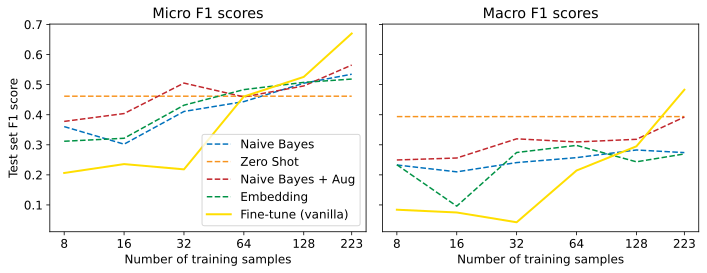

In [64]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

### In-Context and Few-Shot Learning with Prompts

In [65]:
prompt = """\
Translate English to French:
thanks =>
"""

## Leveraging Unlabeled Data

### Fine-Tuning a Language Model

In [66]:
#hide_output
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [67]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

In [68]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

original_input_ids = inputs["input_ids"][0]
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [69]:
data_collator.return_tensors = "pt"

In [77]:
#hide_output
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", eval_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

/tmp/ipykernel_666749/3577247871.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 2.34, 'grad_norm': 3.6467840671539307, 'learning_rate': 4.6917808219178085e-05, 'epoch': 1.0}
{'eval_loss': 1.7904207706451416, 'eval_runtime': 0.5811, 'eval_samples_per_second': 383.757, 'eval_steps_per_second': 12.046, 'epoch': 1.0}
{'loss': 1.7984, 'grad_norm': 3.2645773887634277, 'learning_rate': 4.379280821917808e-05, 'epoch': 2.0}
{'eval_loss': 1.6072020530700684, 'eval_runtime': 0.5796, 'eval_samples_per_second': 384.719, 'eval_steps_per_second': 12.076, 'epoch': 2.0}
{'loss': 1.6309, 'grad_norm': 3.451777458190918, 'learning_rate': 4.066780821917808e-05, 'epoch': 3.0}
{'eval_loss': 1.5296516418457031, 'eval_runtime': 0.5467, 'eval_samples_per_second': 407.893, 'eval_steps_per_second': 12.804, 'epoch': 3.0}
{'loss': 1.531, 'grad_norm': 2.9166834354400635, 'learning_rate': 3.754280821917808e-05, 'epoch': 4.0}
{'eval_loss': 1.3623296022415161, 'eval_runtime': 0.5676, 'eval_samples_per_second': 392.911, 'eval_steps_per_second': 12.334, 'epoch': 4.0}
{'loss': 1.4659, 'grad_

TrainOutput(global_step=1168, training_loss=1.4359465951788914, metrics={'train_runtime': 320.9679, 'train_samples_per_second': 463.747, 'train_steps_per_second': 3.639, 'train_loss': 1.4359465951788914, 'epoch': 16.0})

In [78]:
# hide_output
trainer.push_to_hub("Training complete!")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...es-128-issues-128/model.safetensors:   0%|          | 1.15MB /  438MB            

  ...es-128-issues-128/training_args.bin:   2%|1         |  92.0B / 5.78kB            

CommitInfo(commit_url='https://huggingface.co/RyotaBannai/bert-base-uncased-issues-128-issues-128/commit/c4a6f71d802544e10ddbfd115fd9c47669fd22d1', commit_message='Training complete!', commit_description='', oid='c4a6f71d802544e10ddbfd115fd9c47669fd22d1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/RyotaBannai/bert-base-uncased-issues-128-issues-128', endpoint='https://huggingface.co', repo_type='model', repo_id='RyotaBannai/bert-base-uncased-issues-128-issues-128'), pr_revision=None, pr_num=None)

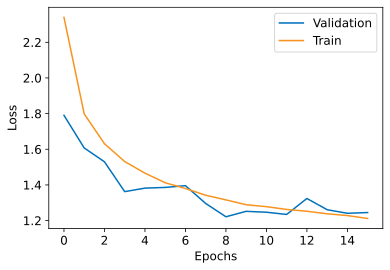

In [79]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")
 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

### Fine-Tuning a Classifier

In [80]:
#hide_output
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA refers to domain adaptation
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

/tmp/ipykernel_666749/2348059469.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6832, 'grad_norm': 1.5778160095214844, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6289410591125488, 'eval_micro f1': 0.057971014492753624, 'eval_macro f1': 0.02370820668693009, 'eval_runtime': 0.1039, 'eval_samples_per_second': 1020.004, 'eval_steps_per_second': 9.623, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6211, 'grad_norm': 1.5018211603164673, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5779900550842285, 'eval_micro f1': 0.016129032258064516, 'eval_macro f1': 0.007662835249042145, 'eval_runtime': 0.1057, 'eval_samples_per_second': 1002.531, 'eval_steps_per_second': 9.458, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5634, 'grad_norm': 1.3903615474700928, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5338892936706543, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1043, 'eval_samples_per_second': 1016.668, 'eval_steps_per_second': 9.591, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5081, 'grad_norm': 1.2375277280807495, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.5004397630691528, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1098, 'eval_samples_per_second': 965.072, 'eval_steps_per_second': 9.104, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4706, 'grad_norm': 1.1475311517715454, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.4749196171760559, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1053, 'eval_samples_per_second': 1006.598, 'eval_steps_per_second': 9.496, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4439, 'grad_norm': 1.0437816381454468, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.45417940616607666, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1056, 'eval_samples_per_second': 1003.911, 'eval_steps_per_second': 9.471, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4105, 'grad_norm': 0.9000270962715149, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.43792933225631714, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0972, 'eval_samples_per_second': 1090.969, 'eval_steps_per_second': 10.292, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3909, 'grad_norm': 0.8778078556060791, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.42617541551589966, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1015, 'eval_samples_per_second': 1044.273, 'eval_steps_per_second': 9.852, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3779, 'grad_norm': 0.765733003616333, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.41710108518600464, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0971, 'eval_samples_per_second': 1092.122, 'eval_steps_per_second': 10.303, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3749, 'grad_norm': 0.8395963311195374, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.4086518883705139, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0974, 'eval_samples_per_second': 1087.995, 'eval_steps_per_second': 10.264, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3572, 'grad_norm': 0.7202380895614624, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.4012548327445984, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0965, 'eval_samples_per_second': 1098.4, 'eval_steps_per_second': 10.362, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3519, 'grad_norm': 0.7252766489982605, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.39497897028923035, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1021, 'eval_samples_per_second': 1038.631, 'eval_steps_per_second': 9.798, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3491, 'grad_norm': 0.6885008215904236, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.38993972539901733, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0973, 'eval_samples_per_second': 1089.472, 'eval_steps_per_second': 10.278, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3334, 'grad_norm': 0.6530835628509521, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.38544291257858276, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1054, 'eval_samples_per_second': 1005.246, 'eval_steps_per_second': 9.483, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3207, 'grad_norm': 0.6145418882369995, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.3818066418170929, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.103, 'eval_samples_per_second': 1028.675, 'eval_steps_per_second': 9.704, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3234, 'grad_norm': 0.65743488073349, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.37903255224227905, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1057, 'eval_samples_per_second': 1002.75, 'eval_steps_per_second': 9.46, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3164, 'grad_norm': 0.5898692011833191, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.37734106183052063, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1054, 'eval_samples_per_second': 1005.865, 'eval_steps_per_second': 9.489, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3089, 'grad_norm': 0.5828271508216858, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.37612253427505493, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1053, 'eval_samples_per_second': 1006.179, 'eval_steps_per_second': 9.492, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2964, 'grad_norm': 0.567206621170044, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.37506726384162903, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1021, 'eval_samples_per_second': 1038.342, 'eval_steps_per_second': 9.796, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.296, 'grad_norm': 0.5905753374099731, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.3740275800228119, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.0936, 'eval_samples_per_second': 1133.027, 'eval_steps_per_second': 10.689, 'epoch': 20.0}
{'train_runtime': 47.1186, 'train_samples_per_second': 4.245, 'train_steps_per_second': 0.424, 'train_loss': 0.40489100515842436, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/2348059469.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.7025, 'grad_norm': 1.6497293710708618, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6324210166931152, 'eval_micro f1': 0.27106227106227104, 'eval_macro f1': 0.11051066734937703, 'eval_runtime': 0.1144, 'eval_samples_per_second': 926.705, 'eval_steps_per_second': 8.743, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.591, 'grad_norm': 1.6476143598556519, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5527438521385193, 'eval_micro f1': 0.1917808219178082, 'eval_macro f1': 0.059829059829059825, 'eval_runtime': 0.1119, 'eval_samples_per_second': 946.876, 'eval_steps_per_second': 8.933, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5083, 'grad_norm': 1.6111170053482056, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.48414894938468933, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.905, 'eval_steps_per_second': 8.905, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.453, 'grad_norm': 1.3233723640441895, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.4484485387802124, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.717, 'eval_steps_per_second': 8.903, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4257, 'grad_norm': 1.322938084602356, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.4255613684654236, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1125, 'eval_samples_per_second': 941.905, 'eval_steps_per_second': 8.886, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3833, 'grad_norm': 1.064047932624817, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.40642791986465454, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.112, 'eval_samples_per_second': 946.439, 'eval_steps_per_second': 8.929, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3713, 'grad_norm': 1.0663694143295288, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.39371129870414734, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1128, 'eval_samples_per_second': 939.31, 'eval_steps_per_second': 8.861, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3491, 'grad_norm': 1.2755404710769653, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.38361018896102905, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1131, 'eval_samples_per_second': 936.965, 'eval_steps_per_second': 8.839, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.345, 'grad_norm': 1.083636999130249, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.3762689232826233, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1135, 'eval_samples_per_second': 933.655, 'eval_steps_per_second': 8.808, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.33, 'grad_norm': 1.2769789695739746, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.37142446637153625, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1128, 'eval_samples_per_second': 940.101, 'eval_steps_per_second': 8.869, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2992, 'grad_norm': 1.021403431892395, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.36801132559776306, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.615, 'eval_steps_per_second': 8.959, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2925, 'grad_norm': 1.062666654586792, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.3651575744152069, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1122, 'eval_samples_per_second': 945.097, 'eval_steps_per_second': 8.916, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2931, 'grad_norm': 0.7972748279571533, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.3622034788131714, 'eval_micro f1': 0.01652892561983471, 'eval_macro f1': 0.007936507936507936, 'eval_runtime': 0.1134, 'eval_samples_per_second': 934.405, 'eval_steps_per_second': 8.815, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.292, 'grad_norm': 1.189602255821228, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.358609676361084, 'eval_micro f1': 0.03278688524590164, 'eval_macro f1': 0.01532567049808429, 'eval_runtime': 0.1117, 'eval_samples_per_second': 949.272, 'eval_steps_per_second': 8.955, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2636, 'grad_norm': 0.9846847057342529, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.35462117195129395, 'eval_micro f1': 0.04878048780487805, 'eval_macro f1': 0.022222222222222223, 'eval_runtime': 0.1128, 'eval_samples_per_second': 939.872, 'eval_steps_per_second': 8.867, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2755, 'grad_norm': 0.9896179437637329, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.35100215673446655, 'eval_micro f1': 0.04878048780487805, 'eval_macro f1': 0.022222222222222223, 'eval_runtime': 0.0945, 'eval_samples_per_second': 1122.191, 'eval_steps_per_second': 10.587, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2599, 'grad_norm': 0.8904661536216736, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.34816357493400574, 'eval_micro f1': 0.04878048780487805, 'eval_macro f1': 0.022222222222222223, 'eval_runtime': 0.1142, 'eval_samples_per_second': 928.195, 'eval_steps_per_second': 8.757, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.262, 'grad_norm': 0.9497030973434448, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.34596699476242065, 'eval_micro f1': 0.04878048780487805, 'eval_macro f1': 0.022222222222222223, 'eval_runtime': 0.1117, 'eval_samples_per_second': 948.958, 'eval_steps_per_second': 8.952, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2474, 'grad_norm': 0.9131394028663635, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.34478312730789185, 'eval_micro f1': 0.07936507936507936, 'eval_macro f1': 0.03367003367003367, 'eval_runtime': 0.1124, 'eval_samples_per_second': 942.874, 'eval_steps_per_second': 8.895, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2269, 'grad_norm': 0.8593357801437378, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.34406545758247375, 'eval_micro f1': 0.07936507936507936, 'eval_macro f1': 0.03367003367003367, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.189, 'eval_steps_per_second': 8.936, 'epoch': 20.0}
{'train_runtime': 48.9164, 'train_samples_per_second': 7.768, 'train_steps_per_second': 0.818, 'train_loss': 0.35856922417879106, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/2348059469.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.6759, 'grad_norm': 1.5847158432006836, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5817846655845642, 'eval_micro f1': 0.23952095808383234, 'eval_macro f1': 0.07855992638601333, 'eval_runtime': 0.1128, 'eval_samples_per_second': 939.656, 'eval_steps_per_second': 8.865, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5315, 'grad_norm': 1.5322734117507935, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.47685912251472473, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1132, 'eval_samples_per_second': 936.696, 'eval_steps_per_second': 8.837, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4534, 'grad_norm': 1.3905117511749268, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.43030449748039246, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.142, 'eval_steps_per_second': 8.935, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4002, 'grad_norm': 1.448929786682129, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.4031708240509033, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1117, 'eval_samples_per_second': 949.389, 'eval_steps_per_second': 8.957, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3687, 'grad_norm': 1.0242056846618652, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.38699856400489807, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1124, 'eval_samples_per_second': 942.646, 'eval_steps_per_second': 8.893, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3561, 'grad_norm': 1.194724202156067, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.3743910789489746, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.284, 'eval_steps_per_second': 8.946, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3416, 'grad_norm': 1.1218445301055908, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.3663868308067322, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1125, 'eval_samples_per_second': 942.301, 'eval_steps_per_second': 8.89, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.326, 'grad_norm': 0.9763582348823547, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.36132389307022095, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1117, 'eval_samples_per_second': 949.112, 'eval_steps_per_second': 8.954, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.314, 'grad_norm': 1.0338928699493408, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.3567841649055481, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1131, 'eval_samples_per_second': 937.395, 'eval_steps_per_second': 8.843, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2949, 'grad_norm': 0.9020114541053772, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.3518275022506714, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1117, 'eval_samples_per_second': 948.998, 'eval_steps_per_second': 8.953, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2866, 'grad_norm': 1.0530974864959717, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.3476932942867279, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.112, 'eval_samples_per_second': 946.026, 'eval_steps_per_second': 8.925, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2687, 'grad_norm': 0.815853476524353, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.3432168662548065, 'eval_micro f1': 0.04878048780487805, 'eval_macro f1': 0.022222222222222223, 'eval_runtime': 0.1005, 'eval_samples_per_second': 1054.698, 'eval_steps_per_second': 9.95, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.254, 'grad_norm': 0.795767605304718, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.3402905762195587, 'eval_micro f1': 0.09523809523809523, 'eval_macro f1': 0.04040404040404041, 'eval_runtime': 0.1144, 'eval_samples_per_second': 926.81, 'eval_steps_per_second': 8.743, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2527, 'grad_norm': 0.8824859857559204, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.3344360888004303, 'eval_micro f1': 0.1791044776119403, 'eval_macro f1': 0.08253968253968254, 'eval_runtime': 0.1129, 'eval_samples_per_second': 939.173, 'eval_steps_per_second': 8.86, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2321, 'grad_norm': 0.9327369928359985, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.3299890160560608, 'eval_micro f1': 0.2463768115942029, 'eval_macro f1': 0.10830527497194165, 'eval_runtime': 0.1132, 'eval_samples_per_second': 936.483, 'eval_steps_per_second': 8.835, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2353, 'grad_norm': 0.9813451170921326, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.327086865901947, 'eval_micro f1': 0.18045112781954886, 'eval_macro f1': 0.08366013071895424, 'eval_runtime': 0.1122, 'eval_samples_per_second': 944.976, 'eval_steps_per_second': 8.915, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2095, 'grad_norm': 0.6788854002952576, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.3248668611049652, 'eval_micro f1': 0.16666666666666666, 'eval_macro f1': 0.07752986251972055, 'eval_runtime': 0.1141, 'eval_samples_per_second': 928.785, 'eval_steps_per_second': 8.762, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.205, 'grad_norm': 0.674981951713562, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.3214026391506195, 'eval_micro f1': 0.2463768115942029, 'eval_macro f1': 0.1092436974789916, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.55, 'eval_steps_per_second': 8.958, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1932, 'grad_norm': 0.6226351261138916, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.3200381398200989, 'eval_micro f1': 0.28169014084507044, 'eval_macro f1': 0.12046783625730995, 'eval_runtime': 0.1138, 'eval_samples_per_second': 931.474, 'eval_steps_per_second': 8.787, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1874, 'grad_norm': 0.6929305791854858, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.31881240010261536, 'eval_micro f1': 0.2676056338028169, 'eval_macro f1': 0.11728395061728396, 'eval_runtime': 0.1121, 'eval_samples_per_second': 945.684, 'eval_steps_per_second': 8.922, 'epoch': 20.0}
{'train_runtime': 51.2164, 'train_samples_per_second': 14.058, 'train_steps_per_second': 1.171, 'train_loss': 0.31933090289433796, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/2348059469.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.642, 'grad_norm': 1.502739429473877, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5062588453292847, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.452, 'eval_steps_per_second': 8.825, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.4636, 'grad_norm': 1.1629191637039185, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.41862204670906067, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.724, 'eval_steps_per_second': 8.96, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3936, 'grad_norm': 1.0406322479248047, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3826642334461212, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1121, 'eval_samples_per_second': 945.97, 'eval_steps_per_second': 8.924, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3685, 'grad_norm': 1.0646071434020996, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.36673808097839355, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.288, 'eval_steps_per_second': 8.937, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3365, 'grad_norm': 0.7280563712120056, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.35829755663871765, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1137, 'eval_samples_per_second': 932.292, 'eval_steps_per_second': 8.795, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3266, 'grad_norm': 0.685004472732544, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.349948912858963, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1122, 'eval_samples_per_second': 944.376, 'eval_steps_per_second': 8.909, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3163, 'grad_norm': 0.8399322032928467, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.33985766768455505, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1112, 'eval_samples_per_second': 952.877, 'eval_steps_per_second': 8.989, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3035, 'grad_norm': 0.8504661917686462, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.33134880661964417, 'eval_micro f1': 0.11023622047244094, 'eval_macro f1': 0.053365193150139385, 'eval_runtime': 0.1132, 'eval_samples_per_second': 936.532, 'eval_steps_per_second': 8.835, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2892, 'grad_norm': 1.1672389507293701, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.32059457898139954, 'eval_micro f1': 0.3310344827586207, 'eval_macro f1': 0.13983213983213982, 'eval_runtime': 0.1136, 'eval_samples_per_second': 932.854, 'eval_steps_per_second': 8.801, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2651, 'grad_norm': 1.1638939380645752, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.31321483850479126, 'eval_micro f1': 0.35135135135135137, 'eval_macro f1': 0.14471614471614472, 'eval_runtime': 0.1125, 'eval_samples_per_second': 941.845, 'eval_steps_per_second': 8.885, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2419, 'grad_norm': 0.7574213147163391, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.3050834834575653, 'eval_micro f1': 0.4155844155844156, 'eval_macro f1': 0.16678984971667898, 'eval_runtime': 0.1135, 'eval_samples_per_second': 934.11, 'eval_steps_per_second': 8.812, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2182, 'grad_norm': 0.8364251852035522, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.29778823256492615, 'eval_micro f1': 0.3841059602649007, 'eval_macro f1': 0.15714285714285714, 'eval_runtime': 0.1127, 'eval_samples_per_second': 940.787, 'eval_steps_per_second': 8.875, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2086, 'grad_norm': 0.677546501159668, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.28983741998672485, 'eval_micro f1': 0.40789473684210525, 'eval_macro f1': 0.16602067183462532, 'eval_runtime': 0.1141, 'eval_samples_per_second': 929.155, 'eval_steps_per_second': 8.766, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1996, 'grad_norm': 0.8219459056854248, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.28171420097351074, 'eval_micro f1': 0.4230769230769231, 'eval_macro f1': 0.16854592435987784, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.723, 'eval_steps_per_second': 8.903, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1854, 'grad_norm': 0.7143457531929016, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.27594703435897827, 'eval_micro f1': 0.43037974683544306, 'eval_macro f1': 0.1696969696969697, 'eval_runtime': 0.1121, 'eval_samples_per_second': 945.591, 'eval_steps_per_second': 8.921, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1668, 'grad_norm': 0.8179482221603394, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.2728102207183838, 'eval_micro f1': 0.43312101910828027, 'eval_macro f1': 0.17180591444157337, 'eval_runtime': 0.1128, 'eval_samples_per_second': 939.767, 'eval_steps_per_second': 8.866, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1591, 'grad_norm': 0.8497889041900635, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.2678561210632324, 'eval_micro f1': 0.4625, 'eval_macro f1': 0.23434343434343438, 'eval_runtime': 0.1127, 'eval_samples_per_second': 940.222, 'eval_steps_per_second': 8.87, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1396, 'grad_norm': 0.42705705761909485, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.26712754368782043, 'eval_micro f1': 0.4720496894409938, 'eval_macro f1': 0.2373737373737374, 'eval_runtime': 0.1124, 'eval_samples_per_second': 942.794, 'eval_steps_per_second': 8.894, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1404, 'grad_norm': 0.6061835289001465, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.2648281753063202, 'eval_micro f1': 0.48148148148148145, 'eval_macro f1': 0.2403160751503156, 'eval_runtime': 0.1116, 'eval_samples_per_second': 949.56, 'eval_steps_per_second': 8.958, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1284, 'grad_norm': 0.5499722361564636, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.26158812642097473, 'eval_micro f1': 0.4634146341463415, 'eval_macro f1': 0.2335334016493437, 'eval_runtime': 0.1125, 'eval_samples_per_second': 942.155, 'eval_steps_per_second': 8.888, 'epoch': 20.0}
{'train_runtime': 56.2908, 'train_samples_per_second': 24.16, 'train_steps_per_second': 1.776, 'train_loss': 0.27464295625686647, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/2348059469.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5568, 'grad_norm': 1.152506947517395, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.4247851073741913, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1132, 'eval_samples_per_second': 936.215, 'eval_steps_per_second': 8.832, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3859, 'grad_norm': 0.7162988781929016, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.36960890889167786, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1126, 'eval_samples_per_second': 941.668, 'eval_steps_per_second': 8.884, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3525, 'grad_norm': 0.9207015037536621, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3530009388923645, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1117, 'eval_samples_per_second': 948.962, 'eval_steps_per_second': 8.952, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3314, 'grad_norm': 0.7595525979995728, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3380112648010254, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1119, 'eval_samples_per_second': 947.011, 'eval_steps_per_second': 8.934, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3094, 'grad_norm': 0.7646647691726685, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.31883504986763, 'eval_micro f1': 0.3783783783783784, 'eval_macro f1': 0.15646840678933105, 'eval_runtime': 0.1124, 'eval_samples_per_second': 943.064, 'eval_steps_per_second': 8.897, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.284, 'grad_norm': 0.7089271545410156, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.3057493269443512, 'eval_micro f1': 0.35135135135135137, 'eval_macro f1': 0.14170274170274172, 'eval_runtime': 0.1118, 'eval_samples_per_second': 947.799, 'eval_steps_per_second': 8.941, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2649, 'grad_norm': 0.8053193092346191, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.28684067726135254, 'eval_micro f1': 0.46540880503144655, 'eval_macro f1': 0.18271604938271604, 'eval_runtime': 0.1128, 'eval_samples_per_second': 939.999, 'eval_steps_per_second': 8.868, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2356, 'grad_norm': 0.7406529784202576, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.2721148431301117, 'eval_micro f1': 0.44871794871794873, 'eval_macro f1': 0.17883597883597885, 'eval_runtime': 0.1148, 'eval_samples_per_second': 923.619, 'eval_steps_per_second': 8.713, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2144, 'grad_norm': 0.6957427263259888, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.25478941202163696, 'eval_micro f1': 0.4720496894409938, 'eval_macro f1': 0.2008783487044357, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.29, 'eval_steps_per_second': 8.946, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.186, 'grad_norm': 0.6144713163375854, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.2459290325641632, 'eval_micro f1': 0.48484848484848486, 'eval_macro f1': 0.2235209235209235, 'eval_runtime': 0.1141, 'eval_samples_per_second': 928.932, 'eval_steps_per_second': 8.764, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1634, 'grad_norm': 0.8054501414299011, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.22979919612407684, 'eval_micro f1': 0.5614035087719298, 'eval_macro f1': 0.32585626020716985, 'eval_runtime': 0.1125, 'eval_samples_per_second': 942.47, 'eval_steps_per_second': 8.891, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1437, 'grad_norm': 0.5435968637466431, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.22384428977966309, 'eval_micro f1': 0.5380116959064327, 'eval_macro f1': 0.29525328472696893, 'eval_runtime': 0.1124, 'eval_samples_per_second': 943.244, 'eval_steps_per_second': 8.899, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1278, 'grad_norm': 0.422552227973938, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.21314050257205963, 'eval_micro f1': 0.5921787709497207, 'eval_macro f1': 0.4170875420875421, 'eval_runtime': 0.1124, 'eval_samples_per_second': 943.234, 'eval_steps_per_second': 8.898, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1155, 'grad_norm': 0.45572808384895325, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.21150702238082886, 'eval_micro f1': 0.5698324022346368, 'eval_macro f1': 0.3583507876986138, 'eval_runtime': 0.1123, 'eval_samples_per_second': 944.196, 'eval_steps_per_second': 8.908, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1011, 'grad_norm': 0.3438173532485962, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.204937145113945, 'eval_micro f1': 0.5988700564971752, 'eval_macro f1': 0.38498418030892834, 'eval_runtime': 0.1129, 'eval_samples_per_second': 938.563, 'eval_steps_per_second': 8.854, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0944, 'grad_norm': 0.40847834944725037, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.20525813102722168, 'eval_micro f1': 0.585635359116022, 'eval_macro f1': 0.38720207788530764, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.884, 'eval_steps_per_second': 8.829, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0866, 'grad_norm': 0.35320374369621277, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.2007741630077362, 'eval_micro f1': 0.6043956043956044, 'eval_macro f1': 0.43674340956949653, 'eval_runtime': 0.1138, 'eval_samples_per_second': 931.333, 'eval_steps_per_second': 8.786, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0784, 'grad_norm': 0.28233033418655396, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.1967221051454544, 'eval_micro f1': 0.6270270270270271, 'eval_macro f1': 0.43282218700658415, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.342, 'eval_steps_per_second': 8.824, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0726, 'grad_norm': 0.28116658329963684, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.19937764108181, 'eval_micro f1': 0.5978260869565217, 'eval_macro f1': 0.410973285973286, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.245, 'eval_steps_per_second': 8.946, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0666, 'grad_norm': 0.2568008303642273, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.19578398764133453, 'eval_micro f1': 0.6304347826086957, 'eval_macro f1': 0.44632646051085767, 'eval_runtime': 0.1124, 'eval_samples_per_second': 942.75, 'eval_steps_per_second': 8.894, 'epoch': 20.0}
{'train_runtime': 66.0541, 'train_samples_per_second': 40.573, 'train_steps_per_second': 2.725, 'train_loss': 0.20854586164156597, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/ipykernel_666749/2348059469.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.5078, 'grad_norm': 0.6805196404457092, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.38563185930252075, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1118, 'eval_samples_per_second': 948.118, 'eval_steps_per_second': 8.945, 'epoch': 1.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3617, 'grad_norm': 0.6155762076377869, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3515637218952179, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.1122, 'eval_samples_per_second': 944.655, 'eval_steps_per_second': 8.912, 'epoch': 2.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3298, 'grad_norm': 0.4971519708633423, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3242148756980896, 'eval_micro f1': 0.3448275862068966, 'eval_macro f1': 0.14444444444444446, 'eval_runtime': 0.1131, 'eval_samples_per_second': 936.913, 'eval_steps_per_second': 8.839, 'epoch': 3.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.3021, 'grad_norm': 0.5784174203872681, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3001924157142639, 'eval_micro f1': 0.42857142857142855, 'eval_macro f1': 0.17098765432098764, 'eval_runtime': 0.1127, 'eval_samples_per_second': 940.393, 'eval_steps_per_second': 8.872, 'epoch': 4.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2731, 'grad_norm': 0.5462802648544312, 'learning_rate': 3e-05, 'epoch': 5.0}
{'eval_loss': 0.2709435522556305, 'eval_micro f1': 0.49696969696969695, 'eval_macro f1': 0.18956521739130436, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.877, 'eval_steps_per_second': 8.904, 'epoch': 5.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2389, 'grad_norm': 0.4523017406463623, 'learning_rate': 3e-05, 'epoch': 6.0}
{'eval_loss': 0.2459835261106491, 'eval_micro f1': 0.5212121212121212, 'eval_macro f1': 0.21661651980800917, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.48, 'eval_steps_per_second': 8.901, 'epoch': 6.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.2042, 'grad_norm': 0.505448043346405, 'learning_rate': 3e-05, 'epoch': 7.0}
{'eval_loss': 0.22248981893062592, 'eval_micro f1': 0.5780346820809249, 'eval_macro f1': 0.31758519010441055, 'eval_runtime': 0.1129, 'eval_samples_per_second': 939.277, 'eval_steps_per_second': 8.861, 'epoch': 7.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1699, 'grad_norm': 0.6282849311828613, 'learning_rate': 3e-05, 'epoch': 8.0}
{'eval_loss': 0.20113371312618256, 'eval_micro f1': 0.6524064171122995, 'eval_macro f1': 0.44842658261097973, 'eval_runtime': 0.1129, 'eval_samples_per_second': 939.15, 'eval_steps_per_second': 8.86, 'epoch': 8.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1431, 'grad_norm': 0.4353282153606415, 'learning_rate': 3e-05, 'epoch': 9.0}
{'eval_loss': 0.19307494163513184, 'eval_micro f1': 0.6702702702702703, 'eval_macro f1': 0.4738962272295606, 'eval_runtime': 0.1135, 'eval_samples_per_second': 934.247, 'eval_steps_per_second': 8.814, 'epoch': 9.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1203, 'grad_norm': 0.38194194436073303, 'learning_rate': 3e-05, 'epoch': 10.0}
{'eval_loss': 0.1854192316532135, 'eval_micro f1': 0.7120418848167539, 'eval_macro f1': 0.5580626780626781, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.878, 'eval_steps_per_second': 8.829, 'epoch': 10.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1018, 'grad_norm': 0.4787774682044983, 'learning_rate': 3e-05, 'epoch': 11.0}
{'eval_loss': 0.17317982017993927, 'eval_micro f1': 0.7336683417085427, 'eval_macro f1': 0.6191764435242697, 'eval_runtime': 0.1125, 'eval_samples_per_second': 942.5, 'eval_steps_per_second': 8.892, 'epoch': 11.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0877, 'grad_norm': 0.31603264808654785, 'learning_rate': 3e-05, 'epoch': 12.0}
{'eval_loss': 0.17229869961738586, 'eval_micro f1': 0.72, 'eval_macro f1': 0.6150050658561298, 'eval_runtime': 0.1123, 'eval_samples_per_second': 943.546, 'eval_steps_per_second': 8.901, 'epoch': 12.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.077, 'grad_norm': 0.26875489950180054, 'learning_rate': 3e-05, 'epoch': 13.0}
{'eval_loss': 0.17442665994167328, 'eval_micro f1': 0.7272727272727273, 'eval_macro f1': 0.6154875283446712, 'eval_runtime': 0.1122, 'eval_samples_per_second': 944.988, 'eval_steps_per_second': 8.915, 'epoch': 13.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0692, 'grad_norm': 0.497290700674057, 'learning_rate': 3e-05, 'epoch': 14.0}
{'eval_loss': 0.16831764578819275, 'eval_micro f1': 0.7208121827411168, 'eval_macro f1': 0.6025783475783476, 'eval_runtime': 0.1127, 'eval_samples_per_second': 940.218, 'eval_steps_per_second': 8.87, 'epoch': 14.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0616, 'grad_norm': 0.1790773719549179, 'learning_rate': 3e-05, 'epoch': 15.0}
{'eval_loss': 0.16961762309074402, 'eval_micro f1': 0.7208121827411168, 'eval_macro f1': 0.6032775161346591, 'eval_runtime': 0.1136, 'eval_samples_per_second': 933.294, 'eval_steps_per_second': 8.805, 'epoch': 15.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0566, 'grad_norm': 0.22537930309772491, 'learning_rate': 3e-05, 'epoch': 16.0}
{'eval_loss': 0.1662721484899521, 'eval_micro f1': 0.7263681592039801, 'eval_macro f1': 0.618193650938749, 'eval_runtime': 0.1128, 'eval_samples_per_second': 939.749, 'eval_steps_per_second': 8.866, 'epoch': 16.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0514, 'grad_norm': 0.2017979770898819, 'learning_rate': 3e-05, 'epoch': 17.0}
{'eval_loss': 0.1647997498512268, 'eval_micro f1': 0.7414634146341463, 'eval_macro f1': 0.6536772486772487, 'eval_runtime': 0.1133, 'eval_samples_per_second': 935.667, 'eval_steps_per_second': 8.827, 'epoch': 17.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0476, 'grad_norm': 0.24478870630264282, 'learning_rate': 3e-05, 'epoch': 18.0}
{'eval_loss': 0.16350306570529938, 'eval_micro f1': 0.7346938775510204, 'eval_macro f1': 0.6366806936721084, 'eval_runtime': 0.1127, 'eval_samples_per_second': 940.29, 'eval_steps_per_second': 8.871, 'epoch': 18.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0446, 'grad_norm': 0.1938926726579666, 'learning_rate': 3e-05, 'epoch': 19.0}
{'eval_loss': 0.15675421059131622, 'eval_micro f1': 0.7464114832535885, 'eval_macro f1': 0.6687688946199585, 'eval_runtime': 0.1136, 'eval_samples_per_second': 932.717, 'eval_steps_per_second': 8.799, 'epoch': 19.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.0413, 'grad_norm': 0.14935554563999176, 'learning_rate': 3e-05, 'epoch': 20.0}
{'eval_loss': 0.1613754779100418, 'eval_micro f1': 0.72, 'eval_macro f1': 0.6249092454971515, 'eval_runtime': 0.1136, 'eval_samples_per_second': 933.132, 'eval_steps_per_second': 8.803, 'epoch': 20.0}
{'train_runtime': 78.9311, 'train_samples_per_second': 56.505, 'train_steps_per_second': 3.547, 'train_loss': 0.16448899613959447, 'epoch': 20.0}


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


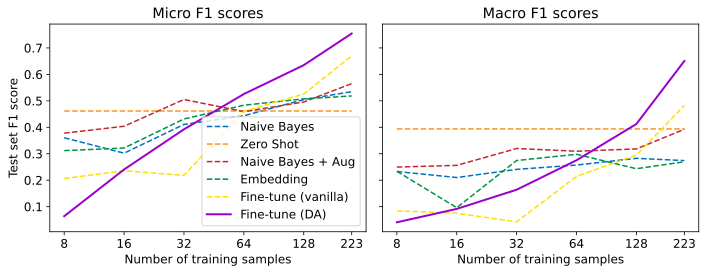

In [81]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

### Advanced Methods

#### Unsupervised data augmentation

<img alt="uda" width="600" caption="Training a model M with UDA (courtesy of Qizhe Xie)" src="images/chapter09_uda.png" id="uda"/>    

#### Uncertainty-aware self-training

<img alt="ust" width="600" caption="The UST method consists of a teacher that generates pseudo-labels and a student that is subsequently trained on those labels; after the student is trained it becomes the teacher and the step is repeated (courtesy of Subhabrata Mukherjee)footnote:[S. Mukherjee and A.H. Awadallah, ["Uncertainty-Aware Self-Training for Few-Shot Text Classification"](https://arxiv.org/abs/2006.15315), (2020).]" src="images/chapter09_ust.png" id="ust"/>

## Conclusion